# Demonstration for Scraping Data from a Web Page to Build a Linear Regression Model
John Bonfardeci (jbonfardeci@rivasolutionsinc.com)

10/28/2022

RIVA Data Science Center of Excellence Training

In [97]:
# Import the libraries we'll be using.
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import re
import numpy as np
import requests

In [98]:
def get_soup(url):
    """Returns a URL as a CSS-searchable BeautifulSoup object."""
    req = requests.get(url)
    html = req.content.decode(encoding='utf-8')
    return BeautifulSoup(html, 'html.parser')

### Scrape the car prices web page.

In [99]:
url = "https://www.kbb.com/cars-for-sale/used/hatchback/toyota/prius/bryan-tx-77802" \
+"?distance=75&bodystyle=hatch&dma=&searchRadius=75&location=&marketExtension=include" \
+"&isNewSearch=false&showAccelerateBanner=false&sortBy=derivedpriceASC&numRecords=100"

card_selector = "div.item-card"
title_selector = "h2.text-bold"
mileage_selector = ".item-card-specifications div ul li > span.text-bold"
price_selector = "span.first-price"

soup = get_soup(url)
cards = soup.select(card_selector)
data = []
for card in cards:
    title = card.select_one(title_selector)
    # Strip all but numbers from the title to get the year.
    year = re.sub(r'[^0-9.]', '', title.text)
    # Strip all but numbers from the mileage.
    mileage = re.sub(r'[^0-9.]', '', card.select_one(mileage_selector).text)
    the_price = card.select_one(price_selector)
    price = None
    # The price isn't accessible retuning None on some. Skip these for now.
    if the_price:
        price = re.sub(r'[^0-9.]', '', the_price.text)
        data.append((str(year), int(mileage), int(price)))

In [88]:
# Preview the first 10 rows of our scraped data.
data[:10]

[('2021', 39529, 29991),
 ('2022', 13635, 31998),
 ('2010', 216853, 5395),
 ('2008', 222135, 6500),
 ('2010', 188654, 7900),
 ('2013', 171423, 9900),
 ('2012', 106888, 10995),
 ('2010', 132364, 11995),
 ('2013', 132710, 12942),
 ('2010', 101312, 12988)]

In [89]:
# Create a Pandas dataframe from the data above.
df = pd.DataFrame(data=data, columns=['year', 'mileage', 'price'])
df.describe()

,mileage,price
count,31.000000,31.000000
mean,87123.483871,20553.516129
std,55580.829691,8737.325013
min,13635.000000,5395.000000
25%,43503.500000,12993.500000
50%,80515.000000,20495.000000
75%,105113.500000,29432.500000
max,222135.000000,31998.000000


In [90]:
# One-hot-encode the 'year' sicne this is a categorical predictor, not a numerical predictor. 
df2 = pd.get_dummies(df)
df2.head()

,mileage,price,year_2008,year_2010,year_2011,year_2012,year_2013,year_2015,year_2016,year_2017,year_2018,year_2019,year_2021,year_2022
0,39529,29991,0,0,0,0,0,0,0,0,0,0,1,0
1,13635,31998,0,0,0,0,0,0,0,0,0,0,0,1
2,216853,5395,0,1,0,0,0,0,0,0,0,0,0,0
3,222135,6500,1,0,0,0,0,0,0,0,0,0,0,0
4,188654,7900,0,1,0,0,0,0,0,0,0,0,0,0


In [100]:
# Set up the matrix of predictors X and the target variable y vector.
X = df2.drop(labels=['price'], axis=1).values
y = df2['price'].values

In [101]:
from sklearn.linear_model import LinearRegression
# Fit the model.
lr = LinearRegression()
column_names = df2.columns.to_list()
column_names.remove('price')
lr.feature_names_in_ = column_names
model = lr.fit(X, y)


#### Fit the estimated prices (Y-hat) on the X-axis by the actual prices on the Y-axis.

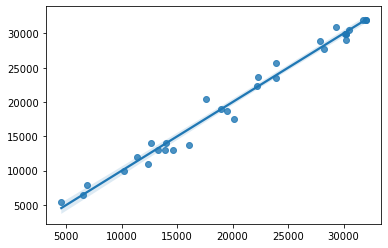

In [93]:
yhat = model.predict(X)
_ = sns.regplot(y=y, x=yhat)

In [110]:
# What are the coefficients for each predictor?
coefficients = [(model.intercept_, 'Y-intercept')]
for coeff, x in zip(model.coef_, column_names):
    coefficients.append((coeff, x))
    
df_est = pd.DataFrame(data=coefficients, columns=['Coefficient (B)', 'Predictor (x)'])
display(df_est)

,Coefficient (B),Predictor (x)
0,27622.871700,Y-intercept
1,-0.080954,mileage
2,-3140.112830,year_2008
3,-5529.427243,year_2010
4,-7109.845138,year_2011
5,-6581.597368,year_2012
6,-3580.372428,year_2013
7,-1150.851280,year_2015
8,437.639448,year_2016
9,5508.972853,year_2017


We can see from the table above that 'mileage' has a coefficient of -0.081. This means that for every one-unit increase in mileage translates to a -0.081 decrease in value. For example, of the mileage is 110,000, we multiply this to get (-0.081)(110,000) = -8,910.

The complete linear formula is:
```
Y-hat = B0 + B1X1 + B2X2 + B3X3 + ..., BiXi
```
Where *e* are the errors and B0 is the y-intercept.

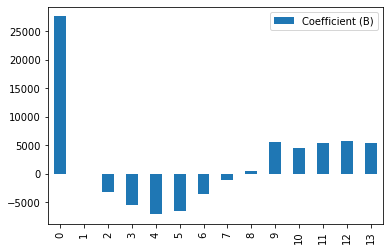

In [111]:
_ = df_est.plot.bar()

In [94]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
stats = """
R^2 (R-squared): %f
MAE (Mean Absolute Error): %f
RMSE (Root Mean Squared Error): %f
""" % (model.score(X,y), mean_absolute_error(y, yhat), mean_squared_error(y, yhat))
print(stats)


R^2 (R-squared): 0.981889
MAE (Mean Absolute Error): 844.799714
RMSE (Root Mean Squared Error): 1338034.411084



### Validate the Model
The assumptions of OLS (Ordinary Least Squares) dicates that residuals (errors) must not be correlated, have a mean of about zero, nor can they be correlated with the predicted values. If we plot the errors by the predicted values, there should be not pattern apparent. It should resemble random noise. This is referred to *constance variance* and officially called *homoskedasticity*.

We typically *standardize* error terms by dividing the difference of the observed and expected values 
by the square root of the expected value.

If the plot shows any curvature, a triangle shape - meaning increasing variance from left to roght, we must log-transform either a numerical predictor, the target variable, or both, to achieve constant variance.

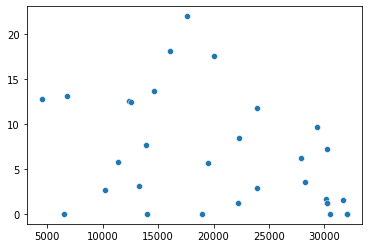

In [95]:
# The scatter plot shows constant variance in the residuals. The model is valid.
resid = np.absolute(y - yhat)
std_resid = resid / np.sqrt(yhat)
_ = sns.scatterplot(y=std_resid, x=yhat)

### What is the estimated worth of my Prius?

In [96]:
my_mileage = [110700]
my_year = [1,0,0,0,0,0,0,0,0,0,0,0]
my_car_data = my_mileage + my_year
val_x = [my_car_data]
my_car_worth = model.predict(val_x)
print(f"My car's estimated worth: ${my_car_worth[0]:,.0f}")

My car's estimated worth: $15,521
